In [119]:
%load_ext autoreload
%autoreload 2

import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
from torchvision import transforms
from torchvision.datasets import MNIST
os.chdir("/nfs/students/winter-term-2020/project-4/schwienb/project-4")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
from src.data.mnist import MNISTDataModule
from src.data.bg_aug_mnist import BgAugMNISTDataModule,BgAugFashionMNISTDataModule
from src.data.fashionmnist import FashionMNISTDataModule
from src.data.coco import COCODataModule

from src.models.bg_aug_pixelcnn import BgAugPixelCNN

from src.models.pixelcnn import PixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images, draw_likelihood_plot, positionalencoding2d, draw_likelihood_plot_ratio
from src.utils.ood_test import plot_roc_auc, test_ood
import torch.nn.functional as F
from torch.autograd import Variable

In [121]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)


42

In [140]:
experiment_name = 'PixelCNN_50E_COCO_1'
dataset = MNISTDataModule
ood_dataset = FashionMNISTDataModule

In [141]:
exp = Experiment(experiment_name)
exp_background = Experiment('PixelCNN_COCO_Mut02')

In [142]:
# exp._setup()
exp.load()
exp_background.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/nfs/students/winter-term-2020/project-4/schwienb/project-4/src/utils/pixelcnn.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


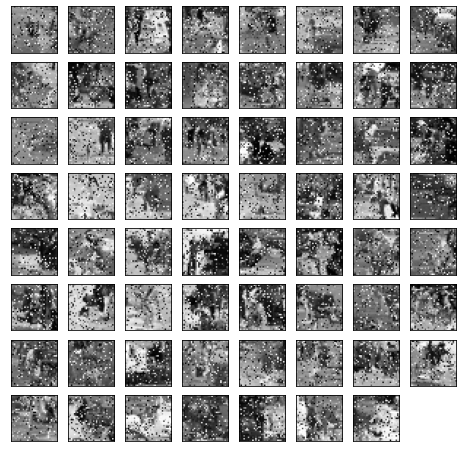

In [143]:
from src.utils.pixelcnn import generate_images
generate_images(exp_background.model, channels=1, img_dim=(32,32))

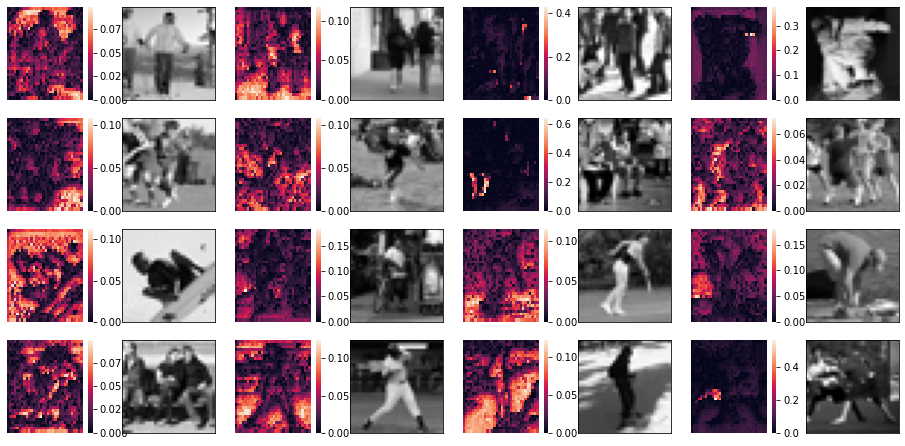

In [126]:
draw_likelihood_plot(exp.dataset.test_dataloader(), exp.model, cmap="rocket", vmax=None, img_index=0)

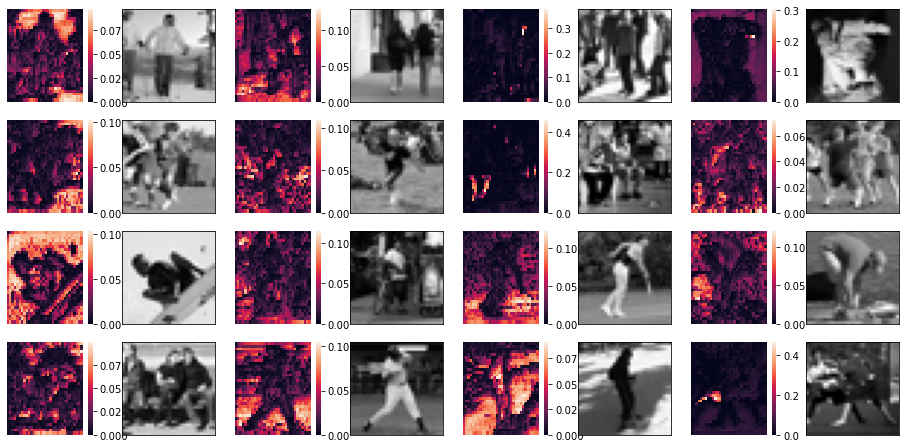

In [127]:
draw_likelihood_plot(exp.dataset.test_dataloader(), exp_background.model, cmap="rocket", vmax=None, img_index=0)

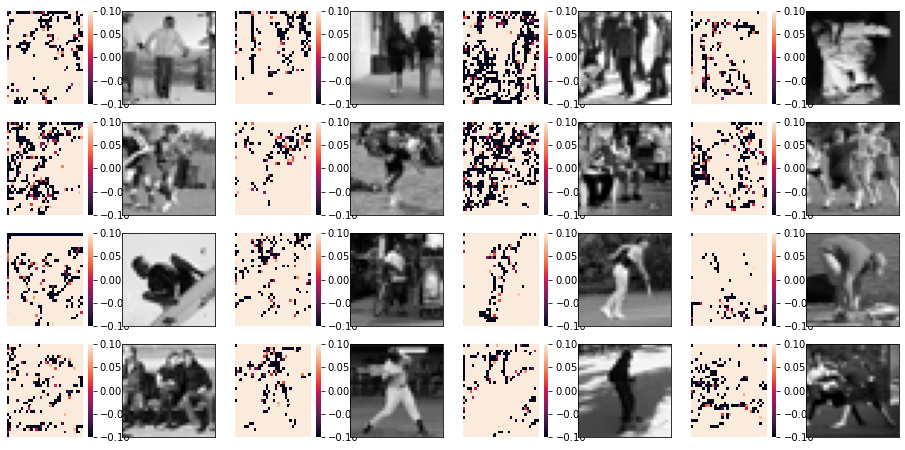

In [128]:
draw_likelihood_plot_ratio(exp.dataset.test_dataloader(), exp.model, exp_background.model, cmap="rocket", vmax=0, img_index=0)

In [129]:
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import DataLoader, random_split
from src.data.coco import COCODataModule

import cv2
transform = [
   transforms.Grayscale(num_output_channels=1), transforms.Resize((32,32), interpolation=Image.BICUBIC), 
    transforms.ToTensor()
]
transform = transforms.Compose(transform)
svhn_test = datasets.SVHN('data/', split='test', transform=transform, download=True)
_, svhn_test = torch.utils.data.random_split(svhn_test, [24332, 1700])
svhn_testloader = DataLoader(svhn_test, batch_size=1, shuffle=False, num_workers=10, drop_last=True, pin_memory=True)


Using downloaded and verified file: data/test_32x32.mat


In [130]:
import gc

# idd = MNISTDataModule
# idd_dataloader = idd()
# idd_dataloader.prepare_data()
# idd_dataloader.setup()

# idd_test = idd_dataloader.test_dataloader()

# odd = FashionMNISTDataModule
# odd_dataloader = odd()
# odd_dataloader.prepare_data()
# odd_dataloader.setup()

# odd_test = odd_dataloader.test_dataloader()

coco_test = exp.dataset.test_dataloader()

idd_test = coco_test
odd_test = svhn_test

In [144]:
from src.models.likelihood_ratio import LikelihoodRatio

In [153]:
# model = LikelihoodRatio(model=exp.model, model_back=exp_background.model, back_weight=1)
# model = exp.model

exp2 = Experiment('PixelCNN_BGAUG02_RNBG_RC_COCO_01')
exp2.load()
model = exp2.model

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [154]:
# model.background_subtraction = False
# model.img_index = 1
idd_result = exp.trainer.test(model, test_dataloaders=[idd_test], verbose=False)

Set SLURM handle signals.


In [155]:
model.svhn = True
model.background_subtraction = False
model.img_index = False
odd_result = exp.trainer.test(model, test_dataloaders=[odd_test], verbose=False)
model.svhn = False


Set SLURM handle signals.


In [156]:
idd_losses = torch.Tensor(list(map(lambda x: x['test_loss'], idd_result))).numpy() 
ood_losses = torch.Tensor(list(map(lambda x: x['test_loss'], odd_result))).numpy() 

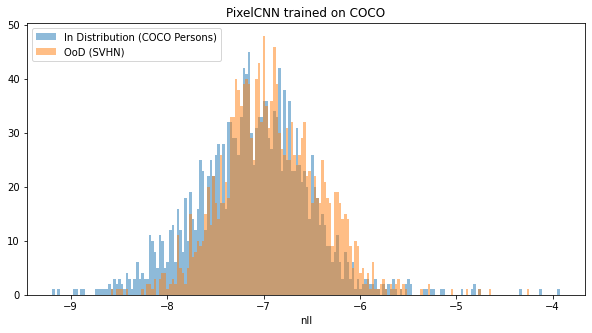

In [157]:
nll_idd_losses = idd_losses *-1
nll_ood_losses = ood_losses * -1

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((nll_idd_losses, nll_ood_losses)), bins=200)[1]
plt.hist(nll_idd_losses, bins, alpha=0.5, label='In Distribution (COCO Persons)')
plt.hist(nll_ood_losses, bins, alpha=0.5, label='OoD (SVHN)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO')
plt.show()


In [158]:
targets = np.concatenate(
    (np.zeros(len(idd_losses)), np.ones(len(ood_losses))))
results = np.concatenate((idd_losses, ood_losses))

 ROC AUC=0.40877


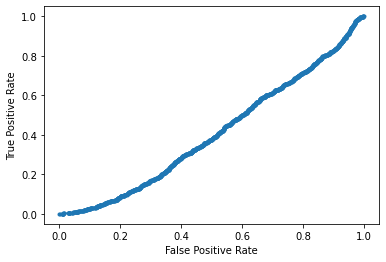

In [159]:
plot_roc_auc(targets, results)

In [21]:
targets, results = test_ood(exp, exp.dataset, svhn_testloader)

FileNotFoundError: [Errno 2] No such file or directory: './data/COCO/foreground_images/'

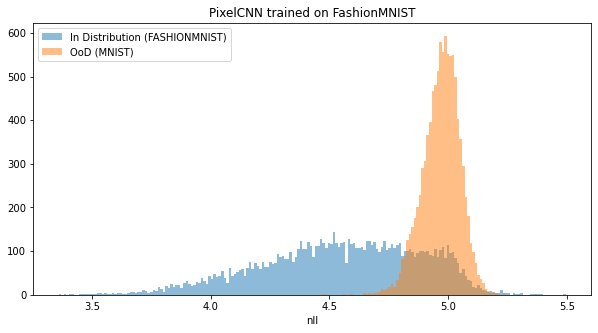

In [88]:
idd_losses = results[0:9999]
ood_losses = results[10000:20000]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses, ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (FASHIONMNIST)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (MNIST)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on FashionMNIST')
plt.show()

 ROC AUC=0.89154


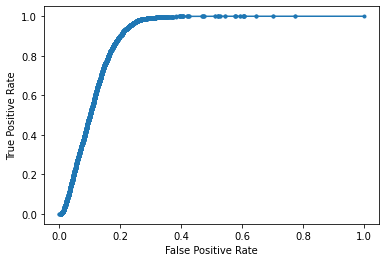

In [87]:
plot_roc_auc(targets, results)